In [211]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble

In [212]:
# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 500

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [213]:
path="../../../../Datafiles/"
file = 'epi_r.csv'
raw_data = pd.read_csv(path + file)
print("there are {} entries in the data frame".format(len(raw_data)))

#raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

there are 20052 entries in the data frame


In [214]:
raw_data.columns
cols = raw_data.columns
# for col in cols:
#     print("col={}".format(col))

In [215]:
raw_data.head(10)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.000,30.000,7.000,559.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.000,18.000,23.000,1439.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,Potato and Fennel Soup Hodge,3.750,165.000,6.000,7.000,165.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,Mahi-Mahi in Tomato Olive Sauce,5.000,nan,nan,nan,nan,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,Spinach Noodle Casserole,3.125,547.000,20.000,32.000,452.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,The Best Blts,4.375,948.000,19.000,79.000,1042.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,Ham and Spring Vegetable Salad with Shallot Vinaigrette,4.375,nan,nan,nan,nan,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,Spicy-Sweet Kumquats,3.750,nan,nan,nan,nan,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,Korean Marinated Beef,4.375,170.000,7.000,10.000,1272.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,Ham Persillade with Mustard Potato Salad and Mashed Peas,3.750,602.000,23.000,41.000,1696.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [216]:
# list(raw_data.columns[:20])

In [217]:
raw_data.rating.describe()

count   20052.000
mean        3.714
std         1.341
min         0.000
25%         3.750
50%         4.375
75%         4.375
max         5.000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

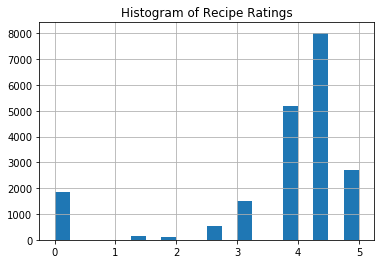

In [218]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [219]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [220]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating','title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)
svr.fit(X,Y)

/Users/lou/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

__Note that this actually takes quite a while to run, compared to some of the models we've done before. Around 5-7 mins. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

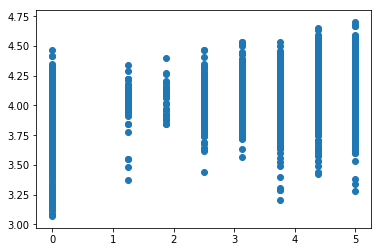

In [221]:
plt.scatter(Y, svr.predict(X))

Now that is a pretty useless visualization. This is because of the discontinous nature of our outcome variable. There's too much data for us to really see what's going on here. If you wanted to look at it you could create histograms, here we'll move on to the scores of both our full fit model and with cross validation. Again if you choose to run it again it will take some time, so you probably shouldn't.

In [222]:
svr.score(X, Y)

-0.003978314483867873

In [223]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

/Users/lou/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/lou/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/lou/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/lou/anaconda3/lib/python3.7/site-packages/sklearn/svm/

array([-0.01787926, -0.02916288, -0.02841122, -0.03767394, -0.01735362])

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

In [224]:
raw_data['rating_binary'] = np.where(raw_data.rating >= 4.0, 1, 0) # either popular or not
# df.dropna(subset=['name', 'born'])
print("row count of raw_data before dropping missing {}".format(len(raw_data)))
raw_data.dropna(subset=['rating']);
print("row count of raw_data after dropping missing {}".format(len(raw_data)))
# print("row count of raw_data is now {}".format(len(raw_data)))
# raw_data.sample(100)
# pd.to_numeric(raw_data['rating'], errors='coerce').sample(100)
# pd.to_numeric(raw_data['rating'], errors='coerce').isnull()

row count of raw_data before dropping missing 20052
row count of raw_data after dropping missing 20052


In [225]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating', 'rating_binary', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = raw_data.rating_binary.sample(frac=0.3, replace=True, random_state=1)
svr.fit(X,Y)

/Users/lou/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.

In [226]:
# todo's:
# # 1. convert data types to ints
# from sklearn import ensemble
# from sklearn.model_selection import cross_val_score
# classifier = DecisionTreeClassifier() 
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)# , random_state=0)  
# classifier.fit(X_train, y_train)

In [227]:
# y_train.sample(20)

In [228]:
# feature_importances = pd.DataFrame(classifier.feature_importances_,
#                                    index = X_train.columns,
#                                     columns=['importance']).sort_values('importance', ascending=False)

list1 = feature_importances.head(36)

In [229]:
top_30_columns = feature_importances.index[0:30]
droppable_columns = []
droppable_columns = top_30_columns[31:]

In [230]:
top_30_columns

Index(['house & garden', 'roast', 'quick & easy', 'bake', 'vegetable',
       'summer', 'lemon', 'citrus', 'bon appétit', 'herb', 'high fiber',
       'sugar conscious', 'fish', 'milk/cream', 'healthy', 'wheat/gluten-free',
       'tomato', 'winter', 'bacon', 'low fat', 'sauté', 'vegan', 'sauce',
       'kidney friendly', 'lunch', 'gourmet', 'side', 'vinegar', 'onion',
       'pasta'],
      dtype='object')

In [239]:
X = X[top_30_columns]
X.isnull().sum()

house & garden       0
roast                0
quick & easy         0
bake                 0
vegetable            0
summer               0
lemon                0
citrus               0
bon appétit          0
herb                 0
high fiber           0
sugar conscious      0
fish                 0
milk/cream           0
healthy              0
wheat/gluten-free    0
tomato               0
winter               0
bacon                0
low fat              0
sauté                0
vegan                0
sauce                0
kidney friendly      0
lunch                0
gourmet              0
side                 0
vinegar              0
onion                0
pasta                0
dtype: int64

In [240]:
Y.isnull().sum()

0

In [242]:
print("there are {} entries in Y,\nand {} entries in X".format(Y.count(), X.count()))

there are 6016 entries in Y,
and house & garden       6016
roast                6016
quick & easy         6016
bake                 6016
vegetable            6016
summer               6016
lemon                6016
citrus               6016
bon appétit          6016
herb                 6016
high fiber           6016
sugar conscious      6016
fish                 6016
milk/cream           6016
healthy              6016
wheat/gluten-free    6016
tomato               6016
winter               6016
bacon                6016
low fat              6016
sauté                6016
vegan                6016
sauce                6016
kidney friendly      6016
lunch                6016
gourmet              6016
side                 6016
vinegar              6016
onion                6016
pasta                6016
dtype: int64 entries in X


In [233]:
if 1 == 0:
    rfc = ensemble.RandomForestClassifier()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
    ## Fit the model on your training data.
    rfc.fit(X_train, y_train) 
    ## And score it on your testing data.
    rfc.score(X_test, y_test)

In [234]:
from sklearn.svm import SVR
svr = SVR()
# raw_data.dropna(subset=['rating', 'rating_binary'], inplace=True)
# raw_data['rating'].count()

# X = raw_data.drop(['rating'], 1).sample(frac=0.3, replace=True, random_state=1)




# df.dropna(subset=['name', 'born'])
# X = raw_data[top_30_columns]
# X.count()

In [235]:
# Y = raw_data.rating_binary.sample(frac=0.3, replace=True, random_state=1)
# Y.count()
svr.fit(X,Y)

/Users/lou/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

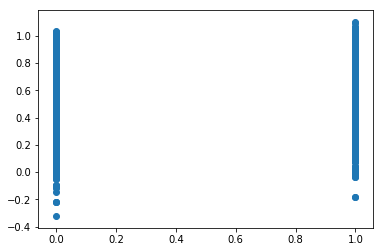

In [236]:
plt.scatter(Y, svr.predict(X))

In [237]:
svr.score(X, Y)

-0.08280932949369713

In [238]:
X.head(20)

,house & garden,roast,quick & easy,bake,vegetable,summer,lemon,citrus,bon appétit,herb,...,sauté,vegan,sauce,kidney friendly,lunch,gourmet,side,vinegar,onion,pasta
235,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
12172,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000
5192,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000
17289,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
10955,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7813,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
19279,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
144,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000
16332,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7751,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000
